# HW4: Structure-from-motion

Ref:

- https://blog.csdn.net/haizimin/article/details/49836077
- https://github.com/jesolem/PCV/blob/master/pcv_book/sfm.py
- multiple view geometry in computer vision
http://cvrs.whu.edu.cn/downloads/ebooks/Multiple%20View%20Geometry%20in%20Computer%20Vision%20(Second%20Edition).pdf

In [101]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import hw3
np.set_printoptions(suppress=True)

## Input Images

In [102]:
DEBUG_IMAGE_INDEX = 1
RANSAC_INLINER_THRESHOLD = 0.25
RANSAC_SAMPLE_NUMBER = 2000

if(DEBUG_IMAGE_INDEX==1):
    image1 = cv2.imread('./data/Mesona1.JPG')
    image2 = cv2.imread('./data/Mesona2.JPG')
    RANSAC_INLINER_THRESHOLD = 0.5
elif(DEBUG_IMAGE_INDEX == 2):
    image1 = cv2.imread('./data/Statue1.bmp')
    image2 = cv2.imread('./data/Statue2.bmp')
    RANSAC_INLINER_THRESHOLD = 0.25
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

## Intrinsic Matrix

In [103]:
intrinsic_matrix1 = np.zeros((3,3))
intrinsic_matrix1 = np.zeros((3,3))
rotation_matrix1, rotation_matrix2 = None, None
transform_matrix1, transform_matrix2 = None, None

if(DEBUG_IMAGE_INDEX == 1):
    intrinsic_matrix1 = np.array([[1.4219, 0.005, 0.5092],
                                  [0, 1.4219, 0.3802],
                                  [0, 0, 0.0010]])
    intrinsic_matrix1 = intrinsic_matrix1 / intrinsic_matrix1[2,2]
    intrinsic_matrix2 = intrinsic_matrix1
else:
    intrinsic_matrix1 = np.array([[5426.566895, 0.678017, 330.096680],
                 [0.000000, 5423.133301, 648.950012],
                 [0.000000, 0.000000, 1.000000]])
    rotation_matrix1 = np.array([[0.140626, 0.989027, -0.045273],
              [0.475766, -0.107607, -0.872965],
              [-0.868258, 0.101223, -0.485678]])
    transform_matrix1 = np.array([67.479439, -6.020049, 40.224911])

    intrinsic_matrix2 = np.array([[5426.566895, 0.678017, 387.430023],
                  [0.000000, 5423.133301, 620.616699],
                  [0.000000, 0.000000, 1.000000]])
    rotation_matrix2 = np.array([[0.336455, 0.940689, -0.043627],
              [0.446741, -0.200225, -0.871970],
              [-0.828988, 0.273889, -0.487611]])
    transform_matrix2 = np.array([62.882744, -21.081516, 40.544052])
    
print("Intrinsic Matrix 1\n", intrinsic_matrix1)
print("Intrinsic Matrix 2\n", intrinsic_matrix2)

if(rotation_matrix1 is not None):
    print('rotation_matrix1\n', rotation_matrix1)
    print('rotation_matrix2\n', rotation_matrix2)
    print('transform_matrix1\n', transform_matrix1)
    print('transform_matrix1\n', transform_matrix2)

Intrinsic Matrix 1
 [[ 1421.9     5.    509.2]
 [    0.   1421.9   380.2]
 [    0.      0.      1. ]]
Intrinsic Matrix 2
 [[ 1421.9     5.    509.2]
 [    0.   1421.9   380.2]
 [    0.      0.      1. ]]


## Feature Points

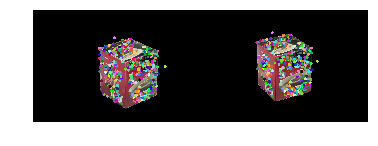

(<matplotlib.image.AxesImage at 0x2753e689b70>,
 (-0.5, 2399.5, 799.5, -0.5),
 None)

In [104]:
sift = cv2.xfeatures2d.SIFT_create()

(keypt1, desc1) = sift.detectAndCompute(image1, None)
(keypt2, desc2) = sift.detectAndCompute(image2, None)

BF_MACTHEr_DISTANCE = 0.65
matches = hw3.brute_force_matcher(desc1, desc2, BF_MACTHEr_DISTANCE)
matched_pt_order = hw3.sort_matched_points(matches)

matched_feature_image = hw3.show_matched_image(image1, image2, keypt1, keypt2, matched_pt_order, draw_line=False, circle_size=10)
plt.imshow(matched_feature_image), plt.axis('off'), plt.show()

## Fundamental and Essential Matrix

In [105]:
def get_normalization_matrix(img_shape):
    '''
        get the normalization matrix
    '''
    T = np.array([[2/img_shape[1], 0, -1],
                   [0, 2/img_shape[0], -1],
                   [0, 0, 1]])
    return T

def normalization(imgpts1, imgpts2, img1, img2):
    '''
        ref: lecture P.54
    '''
    # t1: image1 normalization matrix, t2: image2 normalization matrix
    t1 = get_normalization_matrix(img1.shape)
    t2 = get_normalization_matrix(img2.shape)
    
    # to homography coordinate
    homopts1 = np.array([ [each[0], each[1], 1.0] for each in imgpts1])
    homopts2 = np.array([ [each[0], each[1], 1.0] for each in imgpts2])
    
    num_of_point = len(imgpts1)
    for i in range(num_of_point): 
        
        #最後一項要為1
        p2h = np.matmul(t1, homopts1[i])
        homopts1[i] = p2h/p2h[-1]
        
        p2h1 = np.matmul(t2, homopts2[i])
        homopts2[i] = p2h1/p2h1[-1]
    
    normalpts1 = np.delete(homopts1, -1, axis=1)
    normalpts2 = np.delete(homopts2, -1, axis=1)
    
    return normalpts1, normalpts2, t1, t2

def denormalize_fundamental_mat(normalmat1, normalmat2, normalize_fundamental):
    '''
        ref: Multiple View Geometry in Computer Vision - Algorithm 11.1
    '''
    transpose_normalmat2 = np.transpose(normalmat2)
    return np.matmul(np.matmul(transpose_normalmat2, normalize_fundamental), normalmat1)

def get_fundamental(samplept1, samplept2, img1, img2):
    '''
        ref: Multiple View Geometry in Computer Vision - Chapter 11.1, lecture P.50
    '''
    # normalization the key points
    normalpts1, normalpts2, nomalmat1, normalmat2 = normalization(samplept1, samplept2, img1, img2)
    
    A = np.zeros((len(normalpts1), 9), dtype=np.float64)
    for i in range(len(normalpts1)):
        x, y = normalpts1[i][0], normalpts1[i][1]
        xi, yi = normalpts2[i][0], normalpts2[i][1]
        A[i] = np.array([xi*x, xi*y, xi, yi*x, yi*y, yi, x, y, 1])
    
    # resolve det(f) = 0
    u, s, v = np.linalg.svd(A)
    F = v[-1]
    F = F.reshape(3, 3)
    u, s, v = np.linalg.svd(F)
    s = np.array([[s[0], 0 ,0],
                 [0, s[1], 0],
                 [0 , 0, 0]])
    F = np.matmul(np.matmul(u, s), v)
    
    # homographs coefficient and denormalize the fundamental matrix
    F = denormalize_fundamental_mat(nomalmat1, normalmat2, F)
    F = F/F[-1,-1]
    
    return F

def get_geometric_error(testpts1, testpts2, fundamentalmat, inliner_threshold):
    '''
        ref: Multiple View Geometry 11.4.3
    '''
    error = 0
    inliner_number = 0
    inlinerpts1, inlinerpts2 = np.zeros(testpts1.shape), np.zeros(testpts1.shape)
    for i in range(len(testpts1)):
        
        # transform test points to homography coordinate
        x = np.array([testpts1[i][0], testpts1[i][1], 1])
        xi = np.array([testpts2[i][0], testpts2[i][1], 1])
        
        fx = np.matmul(fundamentalmat, x)
        ftx = np.matmul(np.transpose(fundamentalmat), xi)
        
        m = np.power(np.matmul(np.matmul(np.transpose(xi), fundamentalmat), x), 2)
        d = np.power(fx[0], 2) + np.power(fx[1], 2) + np.power(ftx[0], 2) + np.power(ftx[1], 2)
        
        distance = m/d
        if(distance < inliner_threshold):
            error += distance
            inlinerpts1[inliner_number], inlinerpts2[inliner_number] = testpts1[i], testpts2[i]
            inliner_number += 1
            
    return error, inliner_number, inlinerpts1[:inliner_number, :], inlinerpts2[:inliner_number, :]

def get_essential_mat(K1, K2, F):
    '''
        ref: Multiple View Geometry 9.12
    '''
    if(K1[-1,-1] != 1):
        K1 = K1 / K1[-1,-1]
    if(K2[-1,-1] != 1):
        K2 = K2 / K2[-1,-1]
        
    E = np.dot( K2.T , np.dot(F,K1))
    
    return E
def find_fundamental_by_RANSAC(matchedpt_order, imgpts1, imgpts2, img1, img2, inliner_threshold, ransac_iteration = 2000):
    '''
        ref: Multiple View Geometry 11.6
    '''
    print("Key Point Number\n", len(imgpts1))
    ransac_sample_number = 8
    
    best_error = 0
    best_fundamental = np.zeros((3,3))
    best_inlinernum = 0
    best_inlinerpts1, best_inlinerpts2 = np.zeros((2,1))
    for i in range(ransac_iteration):
        sampts1, sampts2 = hw3.sample_match_points(matchedpt_order, imgpts1, imgpts2, ransac_sample_number)
        f = get_fundamental(sampts1, sampts2, img1, img2)
        error, inlinernum, inlinerpts1, inlinerpts2 = get_geometric_error(imgpts1, imgpts2, f, inliner_threshold)
        if(inlinernum > best_inlinernum):
            best_error = error
            best_fundamental = f
            best_inlinernum = inlinernum
            best_inlinerpts1, best_inlinerpts2 = inlinerpts1, inlinerpts2
    best_essential = get_essential_mat(intrinsic_matrix1, intrinsic_matrix2, best_fundamental)
    print("RANSC Error\n", best_error)
    print("Inliner Number\n", best_inlinernum)
    return best_fundamental, best_essential, best_inlinerpts1, best_inlinerpts2 

# find the fundamnetal matrix
imgpts1, imgpts2 = hw3.get_matched_points(matched_pt_order, keypt1, keypt2)
fundamentalmat, essentialmat, inlinerpts1, inlinerpts2 = find_fundamental_by_RANSAC(matched_pt_order, imgpts1, imgpts2, image1, image2, RANSAC_INLINER_THRESHOLD, RANSAC_SAMPLE_NUMBER)

print('keypts1.shape\n', imgpts1.shape)
print("F\n", fundamentalmat)
print("E\n", essentialmat)
print('inlinerpts1.sahpe\n', inlinerpts1.shape)
print('inlinerpts2.sahpe\n', inlinerpts2.shape)

# by opencv
fundamentalmat_opencv, _= cv2.findFundamentalMat(imgpts1, imgpts2, method =cv2.FM_8POINT + cv2.FM_RANSAC)
essentialmat_opencv = get_essential_mat(intrinsic_matrix1, intrinsic_matrix2, fundamentalmat_opencv)
cv_error, cv_inlinernum, _, _ = get_geometric_error(imgpts1, imgpts2, fundamentalmat_opencv, RANSAC_INLINER_THRESHOLD)

print("CV RANSC Error\n", cv_error)
print("CV Inliner Number\n", cv_inlinernum)
print("F by opencv\n", fundamentalmat_opencv)
print("E by opencv\n", essentialmat_opencv)

Key Point Number
 595
RANSC Error
 60.7744104388
Inliner Number
 412
keypts1.shape
 (595, 2)
F
 [[-0.00000009 -0.00000209 -0.00043533]
 [ 0.00000134 -0.00000042  0.01711873]
 [-0.00038527 -0.01601295  1.        ]]
E
 [[ -0.19158908  -4.21921345  -1.81559205]
 [  2.7016019   -0.8454485   25.07782087]
 [  0.10613463 -24.50378188   0.77274683]]
inlinerpts1.sahpe
 (412, 2)
inlinerpts2.sahpe
 (412, 2)
CV RANSC Error
 37.6963815441
CV Inliner Number
 267
F by opencv
 [[ 0.00000085  0.00001079 -0.00566836]
 [-0.00001176  0.00000077  0.02057989]
 [ 0.0035924  -0.01913668  1.        ]]
E by opencv
 [[  1.71602197  21.82061742  -1.6123409 ]
 [-23.76041913   1.54885652  21.16178468]
 [ -0.63231573 -18.9846151    0.63602578]]


## Draw Epipolar Lines

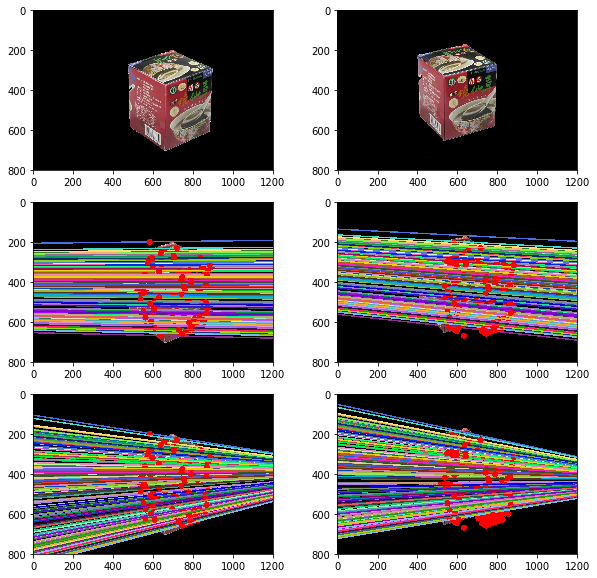

In [106]:
def compute_correspond_epilines(keypts, which_image, fundamental):
    '''
        ref: https://github.com/opencv/opencv/blob/f5801ee7dac4114ac2995a5fd3866ac7775752f7/modules/calib3d/src/fundam.cpp#L836
        l = Fx'
        l' = F^Tx
    '''
    lines = np.zeros((len(keypts), 3))
    
    if (which_image == 2):
        fundamental = np.transpose(fundamental)
    
    for i, p in enumerate(keypts):
        hp = np.array([p[0], p[1], 1])
        l = np.matmul(fundamental, np.transpose(hp))
        
        a, b, c = l[0], l[1], l[2]
        check = a*a + b*b
        if check != 0:
            check = np.sqrt(check)
        else:
            check = 1
        lines[i] = np.array([a/check, b/check ,c/check])
        
    return lines

def draw_epilines(img1, img2, lines, pts1, pts2, colors):
    '''
        ref: https://docs.opencv.org/3.4.4/da/de9/tutorial_py_epipolar_geometry.html
        x0, y0 = (0, -b/c)
        x1, y1 = (w, -(aw+c)/b)
    '''
    imgA = np.copy(img1)
    imgB = np.copy(img2)
    h, w, _ = img1.shape
    
    i=0
    for r,pt1, pt2 in zip(lines, pts1, pts2):
        x0, y0 = (0, int(-r[2]/r[1]))
        x1, y1 = (w, int(-(r[0]*w+r[2])/r[1]))
        imgA = cv2.line(imgA, (x0, y0), (x1, y1), colors[i], 5)
        imgA = cv2.circle(imgA, (int(pt1[0]), int(pt1[1])), 15, (255, 0, 0), -1)
        imgB = cv2.circle(imgB, (int(pt2[0]), int(pt2[1])), 15, (255, 0, 0), -1)
        i += 1
    return imgA, imgB

# prepare line color
colors = np.zeros((len(inlinerpts1), 3))
for i in range(len(inlinerpts1)):
    colors[i] = tuple(np.random.randint(0, 255, 3).tolist())

# show image epilines
lines1 = compute_correspond_epilines(inlinerpts2, 2, fundamentalmat)
img3, _ = draw_epilines(image1, image2, lines1, inlinerpts1, inlinerpts2, colors)
lines2 = compute_correspond_epilines(inlinerpts1, 1, fundamentalmat)
img4, _ = draw_epilines(image2, image1, lines2, inlinerpts1, inlinerpts2, colors)

# by opencv
lines3 = cv2.computeCorrespondEpilines(inlinerpts2, 2, fundamentalmat_opencv)
lines3 = lines3.reshape(-1,3)
img5, _ = draw_epilines(image1, image2, lines3, inlinerpts1, inlinerpts2, colors)
lines4 = cv2.computeCorrespondEpilines(inlinerpts1, 1, fundamentalmat_opencv)
lines4 = lines4.reshape(-1,3)
img6, _ = draw_epilines(image2, image1, lines4, inlinerpts1, inlinerpts2, colors)

plt.figure(figsize=(10, 10))
plt.subplot(321), plt.imshow(image1)
plt.subplot(322), plt.imshow(image2)
plt.subplot(323), plt.imshow(img3)
plt.subplot(324), plt.imshow(img4)
plt.subplot(325),plt.imshow(img5)
plt.subplot(326),plt.imshow(img6)
plt.show()

## Linear Triangulation
project matirx = K[R|t] = 3x4

camera matrix = intrinsic matrix = k = 3x3

external rotation matrix = R = 3x3

translation matrix = t = 1x3

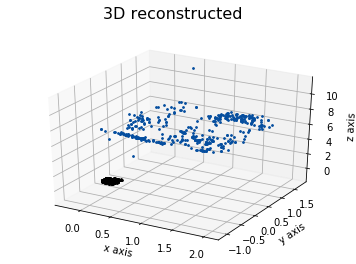

In [107]:
def combine_external(r, t):
    ex = np.array([[r[0,0], r[0,1], r[0,2], t[0]],
                   [r[1,0], r[1,1], r[1,2], t[1]],
                   [r[2,0], r[2,1], r[2,2], t[2]],])
    return ex
def get_camera_matrix(e, k1, k2):
    '''
        ref: Multiple View Geometry 9.13
    '''
    # check the intrinc matrix Homogeneous coefficient
    if(k1[-1,-1] != 1.):
        k1 = k1/k1[-1,-1]
    if(k2[-1,-1] != 1.):
        k2 = k2/k2[-1,-1]
    
    # camera 1 project matrix
    I = np.array([[1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]])
    p1 = np.matmul(k1, combine_external(I, [0, 0, 0]))

    # skew-symmetric
    W = np.array([[0, -1, 0], 
                  [1, 0, 0], 
                  [0, 0, 1]])
    
    U, S, Vt = np.linalg.svd(e)
    R1 = np.matmul(np.matmul(U, W), Vt)
    R2 = np.matmul(np.matmul(U, W.T), Vt)
    t= U[:,-1].reshape(3,1)

    # Thre have four camera direction (ref: Multiple View Geometry 9.14)
    p2_matrixs = np.zeros((4, 3, 4))
    p2_matrixs[0] = np.matmul(k2, combine_external(R1, t))
    p2_matrixs[1] = np.matmul(k2, combine_external(R2, t))
    p2_matrixs[2] = np.matmul(k2, combine_external(R1, -t))
    p2_matrixs[3] = np.matmul(k2, combine_external(R2, -t))
    
    return p1, p2_matrixs

def get_external(e):
    '''
        get external parameter
        ref: homework lecture page 3
    '''
    w = np.array([[0.0, -1.0, 0.0],[1.0, 0.0, 0.0],[0.0, 0.0, 1.0]])
    z = np.array([[0.0, 1.0, 0.0],[-1.0, 0.0, 0.0],[0.0, 0.0, 0.0]])
    
    U, S, V = np.linalg.svd(e)
    m = (S[0] + S[1])/2
    S[0] = m
    S[1] = m
    S[2] = 0

    t = np.matmul(np.matmul(U, z), U.T)
    t = np.array([-t[1,2], t[0,2], -t[0,1]])

    R1 = np.matmul(np.matmul(U, w.T), V)
    R2 = np.matmul(np.matmul(U, w), V)

    if(np.linalg.det(R1)==-1.0):
        R1 = -1*R1
        R2 = -1*R2
        
    return t, R1, R2

def linear_LS_Triangulation(x1, p1, x2, p2):
    '''
        ref: 1995 Triangulation, ch5.1 Linear Triangulation
        https://perception.inrialpes.fr/Publications/1997/HS97/HartleySturm-cviu97.pdf
    '''
    A = np.array([x1[0]*p1[2,:]-p1[0,:], 
                  x1[1]*p1[2,:]-p1[1,:],
                  x2[0]*p2[2,:]-p2[0,:],
                  x2[1]*p2[2,:]-p2[1,:]])
    
    U, S, V = np.linalg.svd(A)
    X = V[-1]/V[-1,3]
    return X

def in_front_of_camera(T, R, pts,OpenCV=False):
    NumOfPoints = 0
    Camera_Center = -np.dot(np.transpose(R),T)
    View_Directopm = np.transpose(R)[2,:]
    for i in range(pts.shape[1]):
        if OpenCV:
            hp = pts[:,i]
            hp = hp/hp[-1]
            X_Camera_Center = hp[:3] - Camera_Center
        else: 
            X_Camera_Center = pts[i] - Camera_Center
        if np.dot(X_Camera_Center,View_Directopm) > 0 :
            NumOfPoints = NumOfPoints + 1
    return NumOfPoints

def get_triangulatepts(e, x1, x2, p1, p2):
    
    T, R1, R2 = get_external(e)
    
    front_count = 0
    project_points = np.zeros((x1.shape[0], 3))
    
    # linear triangulate
    for i in range(x1.shape[0]):
        x = linear_LS_Triangulation(x1[i], p1, x2[i], p2)
        project_points[i] = x[0:3]
    front_count = in_front_of_camera(T, R1, project_points)
    
    return project_points, front_count

def triangulate_points(e, x1, x2, k1, k2, r1=None, r2=None, t1=None, t2=None):
    
    p1 = None
    p2 = None
    
    if(r1 is not None):
        t1 = -np.matmul(r1, t1)
        t2 = -np.matmul(r2, t2)
        p1 = np.matmul(k1, combine_external(r1, t1))
        p2 = np.matmul(k2, combine_external(r2, t2))
        
        triangulation_points, front_count = get_triangulatepts(e, x1, x2, p1, p2)
        
    else:
        p1, p2_matrixs = get_camera_matrix(e, k1, k2)

        max_front_count = 0
        correct_p2_index = -1
        triangulation_points = np.zeros((x1.shape[0], 3))

        for p2_index, the_p2 in enumerate(p2_matrixs):

            project_points, front_count = get_triangulatepts(e, x1, x2, p1, the_p2)       
            if(front_count > max_front_count):
                max_front_count = front_count
                triangulation_points = np.copy(project_points)
                p2 = the_p2

    return triangulation_points, p1, p2

def show_cloud_points(pts, cv_pts=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle('3D reconstructed', fontsize=16)
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    for i, p in enumerate(pts):
        xs = p[0]
        ys = p[1]
        zs = p[2]
        ax.scatter(xs, ys, zs, color='#054E9F', s=3)
        
    if(cv_pts is not None):
        for i in range(cv_pts.shape[1]):
            hp = cv_pts[:,i] 
            x = hp[0]
            y = hp[1]
            z = hp[2]
            ax.scatter(x, y, z, color='#000000', s=3)
    plt.show()

def get_cv_projectpts(pts):
    projectpts = np.transpose(pts)
    return projectpts

# our triangulate method
project_pts, p1, p2 = triangulate_points(essentialmat,
                                         inlinerpts1, inlinerpts2,
                                         intrinsic_matrix1, intrinsic_matrix2,
                                         rotation_matrix1, rotation_matrix2,
                                         transform_matrix1, transform_matrix2)

# opencv triagulate method, need transform the format of inliner points
cv_inlinerpts1 = get_cv_projectpts(inlinerpts1)
cv_inlinerpts2 = get_cv_projectpts(inlinerpts2)
cloudpts1_cv = cv2.triangulatePoints(p1, p2, cv_inlinerpts1, cv_inlinerpts2)

show_cloud_points(project_pts, cloudpts1_cv)

## Save Data For MatLab

In [108]:
t,R1,R2 = get_external(essentialmat)
camera_matrix = np.matmul( intrinsic_matrix1, combine_external(R1.T, t) )
file_name = ''

if(DEBUG_IMAGE_INDEX == 1):
    file_name = 'Mesona1'
elif (DEBUG_IMAGE_INDEX == 2):
    file_name = 'Statue1'
else:
    file_name = 'our'
    
np.savetxt("./data/two_d_points_"+file_name+".csv", inlinerpts1, delimiter=",")
np.savetxt("./data/three_d_points_"+file_name+".csv", project_pts, delimiter=",")
np.savetxt("./data/camera_matrix_"+file_name+".csv", camera_matrix, delimiter=",")